# TP2 : Multi-Layer Perceptrons

In [1]:
#imports
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
from time import time
import matplotlib.pyplot as plt
import numpy as np
import warnings

In [2]:
#load dataset
mnist = fetch_openml('mnist_784')

## [1] Echantillonage du jeu de données et séparation en entraînement/test
*NB* : Au vu des temps d'exécution constatés, nous nous sommes limité à 1/10 du jeu de données initial, soit 7000 images au lieu des 70000 demandées.

In [3]:
#choose sample size
dataset_length = len(mnist.data)
sample_size = 7000
sample_size = min(dataset_length,sample_size)

#extract sample from dataset
sample_indexes = np.random.randint(dataset_length, size= sample_size)
data, target = np.array([mnist.data[i] for i in sample_indexes]), np.array([mnist.target[i] for i in sample_indexes])

#extract train/test according to the proportion given in the subject
train_size = 49000/70000 #keep the given proportion
d_train, d_test, l_train, l_test = train_test_split(data,target,train_size = train_size, random_state = 42)

## [2] Premiers réseaux de neurones

#### Construire un modèle de classification ayant comme paramètre :hidden_layer_sizes = (50) puis calculez la précision du classifieur

In [4]:
mlp = MLPClassifier(hidden_layer_sizes=(50), random_state=42)
mlp.fit(d_train, l_train)
score = mlp.score(d_test, l_test)

print(score)

0.8728571428571429


#### Afficher la classe de l’image 4 et sa classe prédite

prediction : 1
actual : 1


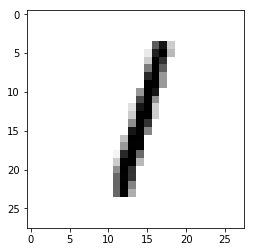

In [5]:
#Test de prediction = valeur réel 
img_index = 3 #4th image of the dataset
images = data.reshape((-1, 28, 28)) 
plt.imshow(images[img_index],cmap=plt.cm.gray_r,interpolation="nearest") 
res = mlp.predict(data[img_index:img_index+1])[0]
print("prediction :",res)
print("actual :",target[img_index])

#### Calculez la précision en utilisant le package : metrics.precision_score(ytest_pr, ypredTest_pr,average='micro').

In [6]:
res = mlp.predict(d_test)
precision = metrics.precision_score(l_test,
                                    res, 
                                    average='micro')
print(precision)

0.8728571428571429


## [3] Analyse : Nombres de couches et neurones

#### Varier le nombre de couches de 1 entre (2 et 100) couches, et recalculer la précision du classifieur.

In [ ]:
best_layers_nb = 0
layers_nb_set = [2,5,15,20,25,35,45,55,65]
best_score = 0
plot = ([],[],[])

neurons = np.geomspace(80, 40, num=100, dtype=int)#reduce neuron number gradually to ensure convergence

start = time() #TIMER START
for layers_nb in layers_nb_set:
    start_iter = time()
    mlp = MLPClassifier(hidden_layer_sizes=neurons[:layers_nb])
    mlp.fit(d_train, l_train)
    prediction = mlp.predict(d_test)
    score = metrics.precision_score(l_test, prediction, average='micro')
    duration_iter = time()-start
    if score > best_score:
        best_score = score
        best_layers_nb = layers_nb
    plot[0].append(layers_nb)
    plot[1].append(score)
    plot[2].append(duration_iter)
    print("Execution time for",layers_nb,duration_iter,"s")
    
duration = time()-start #TIMER END

fig=plt.figure()
ax=fig.add_subplot(111, label="precision")
ax2=ax.twinx()

ax.set_xlabel("n layers")
ax.set_ylabel("precision (%)")
ax.set_title("Precision et temps d'exécution en fonction du nombre de couches utilisées")
ax.plot(plot[0],plot[1])
ax.plot([best_layers_nb],[best_score], marker= 'x', color='r')

ax2.set_ylabel("temps (s)")
ax2.plot(plot[0],plot[2],color='r')

print("Optimal layers number :",best_layers_nb, "( score :",best_score,")")
    

Execution time for 2 7.285797834396362 s


#### Interprétation
On observe que la précision augmente graduellement puis chute rapidement lorsque l'on dépasse 25 couches.

Puisque le temps d'exécution augmente lui fortement avec le nombre de couches, il semble préférable de se limiter à moins d'une vingtaine de couches pour notre analyse, voire moins d'une sizaine pusique là différence en précision est très faible.

On notera cependant que le nombre de neurones par couche joue probablement un rôle déterminant dans cette évolution, d'où la nécessité de l'analyse suivante.

#### Construire cinq modèles de classification des données mnist avec des réseaux qui ont respectivement de 1 à 10 couches cachées, et des tailles de couches entre 10 et 300 neurones au choix d’une façon aléatoire.

In [ ]:
def build_random_models(n,layers_nb_range, layers_size_range):
    layers_nb = np.random.randint(low = layers_nb_range[0],high = layers_nb_range[1], size = n)
    layers_sizes = np.random.randint(low = layers_size_range[0],high = layers_size_range[1], size = n)
    res = []
    for i in range(n):
        nb = layers_nb[i]
        size = layers_sizes[i]
        model = MLPClassifier(hidden_layer_sizes=[size for j in range(nb)])
        res.append((model, nb, size))
    return res

In [ ]:
models = build_random_models(5,(1,11),(10,301))
results = []
for model, nb, size in models:
    start = time()
    model.fit(d_train, l_train)
    prediction = model.predict(d_test)
    score = metrics.precision_score(l_test, prediction, average='micro')
    duration = time()-start
    print("Executed",nb,size,"score :",score,"in",duration,"second")
    results.append((score,nb,size,duration))
results = sorted(results)
for score, nb, size, duration in result:
    print("Layers :",nb,"Neurons :",size,"Precision :",score*100,"%","Exec :",duration,"s")



#### Interprétation
La précision du modèle augmente avec le nombre de couches(comme vu précedemment) mais surtout avec le nombre de neurones par couche. Etendre ce nombre de neurones représente cependant un coût en temps. Pour une itération, nous avons obtenu un modèle optimal à 94% de précision, avec 10 couches et 251 neurones par courche mais dont l'entraînement + prédiction prenait plus d'une minute sur 7000 données.

Un bon compromis semble être trouvé avec un modèle une cinquantaine de neurones sur 8 couches, soit 300 neurones au total, qui obtient un score > 90% pour 20 sec de temps d'exécution total.

Par la suite, on conservera ce nombre de 8 couches et 300 neurones comme référence.
En revanche, on répartira les neurones de façon moins uniforme entre les couches, par exemple en utilisant np.geomspace pour obtenir une répartition logarithmique.

## [4] Analyse des paramètres supplémentaires

In [ ]:
#Common parameters for the rest of the analysis
layers_nb = 6
layers_size = 50

up_size = 1.25 * layers_size
down_size = 0.75*layers_size

neurons = np.geomspace(up_size, down_size, num=layers_nb, dtype=int)#reduce neuron number gradually to ensure convergence

#### Algorithmes d'optimisation

In [ ]:
algo_set = ['lbfgs', 'sgd', 'adam']
plot = ([],[],[],[],[])
for algo in algo_set:
    print("Algo :",algo)
    start = time()#TIMER START
    
    mlp = MLPClassifier(hidden_layer_sizes=neurons, solver = algo)
    mlp.fit(d_train, l_train)
    prediction = mlp.predict(d_test)
    
    duration = time() - start #TIMER END
    
    recall = metrics.recall_score(l_test, prediction, average = 'micro')
    score = metrics.precision_score(l_test, prediction, average='micro')
    error = metrics.zero_one_loss(l_test, prediction)
    
    plot[0].append(algo)
    plot[1].append(score)
    plot[2].append(recall)
    plot[3].append(error)
    plot[4].append(duration)

In [ ]:
fig=plt.figure()
ax1=fig.add_subplot(111, label="precision")
ax2=ax1.twinx()
ax3=ax2.twinx()
ax4=ax3.twinx()

ax1.plot(plot[0],plot[1],linestyle='None',marker='o',color='r')
ax1.set_ylabel("Precision (%)")
ax2.plot(plot[0],plot[2],linestyle='None',marker='o',color='b')
ax2.set_ylabel("Recall (%)")
ax3.plot(plot[0],plot[3],linestyle='None',marker='o',color='g')
ax3.set_ylabel("Error")
ax4.plot(plot[0],plot[4],linestyle='None',marker='X',color='r')
ax4.set_ylabel("Execution(s)")
    

#### Fonctions d'activations

In [ ]:
function_set = ['identity', 'logistic', 'tanh', 'relu']
plot = ([],[],[],[],[])
for function in function_set:
    print("Function :",function)
    start = time()#TIMER START
    
    mlp = MLPClassifier(hidden_layer_sizes=neurons, activation = function)
    mlp.fit(d_train, l_train)
    prediction = mlp.predict(d_test)
    
    duration = time() - start #TIMER END
    
    recall = metrics.recall_score(l_test, prediction, average = 'micro')
    score = metrics.precision_score(l_test, prediction, average='micro')
    error = metrics.zero_one_loss(l_test, prediction)
    
    plot[0].append(function)
    plot[1].append(100*score)
    plot[2].append(100*recall)
    plot[3].append(error)
    plot[4].append(duration)

In [ ]:
fig=plt.figure()
ax1=fig.add_subplot(111, label="precision")
ax2=ax1.twinx()
ax3=ax2.twinx()
ax4=ax3.twinx()

ax1.plot(plot[0],plot[1],linestyle='None',marker='o',color='r')
ax1.set_ylabel("Precision (%)")
ax2.plot(plot[0],plot[2],linestyle='None',marker='o',color='b')
ax2.set_ylabel("Recall (%)")
ax3.plot(plot[0],plot[3],linestyle='None',marker='o',color='g')
ax3.set_ylabel("Error")
ax4.plot(plot[0],plot[4],linestyle='None',marker='X',color='r')
ax4.set_ylabel("Execution(s)")

#### Régulation L2

In [ ]:
alpha_set = [10**(-i) for i in range(8,0,-1)]
plot = ([],[],[],[],[])
for alpha in alpha_set:
    print("Regulation L2 :",alpha)
    start = time()#TIMER START
    
    mlp = MLPClassifier(hidden_layer_sizes=neurons, alpha = alpha)
    mlp.fit(d_train, l_train)
    prediction = mlp.predict(d_test)
    
    duration = time() - start #TIMER END
    
    recall = metrics.recall_score(l_test, prediction, average = 'micro')
    score = metrics.precision_score(l_test, prediction, average='micro')
    error = metrics.zero_one_loss(l_test, prediction)
    
    plot[0].append(alpha)
    plot[1].append(100*score)
    plot[2].append(100*recall)
    plot[3].append(error)
    plot[4].append(duration)

In [ ]:
fig=plt.figure()
ax1=fig.add_subplot(111, label="precision")
ax2=ax1.twinx()
ax3=ax2.twinx()
ax4=ax3.twinx()

ax1.plot(plot[0],plot[1],linestyle='None',marker='o',color='r')
ax1.set_ylabel("Precision (%)")
ax2.plot(plot[0],plot[2],linestyle='None',marker='o',color='b')
ax2.set_ylabel("Recall (%)")
ax3.plot(plot[0],plot[3],linestyle='None',marker='o',color='g')
ax3.set_ylabel("Error")
ax4.plot(plot[0],plot[4],linestyle='None',marker='X',color='r')
ax4.set_ylabel("Execution(s)")

## FIN TP2